In [1]:
# !pip install caer canaro gs
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc # for garbage collection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# All image in the model must have one size. 
# So we need resize all images in data set
# Let's it will be images wiht 80x80 size

IMG_SIZE = (80,80)
channels = 1 # Cause we will use only grayscale 
char_path = r'../input/the-simpsons-characters-dataset/simpsons_dataset'

In [3]:
# Посмотрим все папки с фотографиями персонажей, посмотрим сколько
# В каждой папке картинок, соханим это в словаре и пока будем 
# С 10ю папками в которх больше всего лежит изображений

#Вообще получился не очень эфишент код, так как его O notation 
# = n^2. Но я его не заккоментирую для примера 

d = {}
for i in os.listdir(char_path): # os.listdir() method in python is used to get the list of all files and directories in the specified directory
    img_path = f'{char_path}/{i}'
    
    counter = 0
    for k in os.listdir(img_path):
        counter += 1
        
    d[i] = counter
    
# Better work in this way

d = {}
for char in os.listdir(char_path):
    d[char] = len(os.listdir(os.path.join(char_path,char)))
    
# Sort this dict 
d = caer.sort_dict(d, descending=True)

In [4]:
# Возьмем 10 имен персонажей, у которых наибольшее кол-во img
top_10 = []
for i in range(10):
    top_10.append(d[i][0])

In [5]:
# Create the training data
train = caer.preprocess_from_dir(char_path, top_10, IMG_SIZE=IMG_SIZE, channels=channels, isShuffle=True, verbose=0)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 51s


/opt/conda/lib/python3.7/site-packages/caer/core.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(obj, dtype=dtype, order=order)


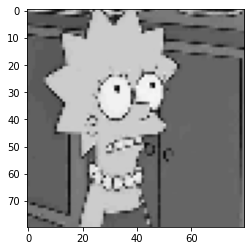

In [6]:
plt.imshow(train[1189][0], cmap='gray')
plt.show()

In [7]:
# Separate labels and features in two separate lists

# Можно сделать так
# labels,features = [], []
# for i in train:
#     labels.append(i[1])
#     features.append(i[0])
    
#Но лучше сделать вот так

features, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [8]:
# Normalization. Features -->(0,1). 
# We need it to fast data processing
features = caer.normalize(features)

# Also we want to convert labels from numerical integers 
# To binary class vectors
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels, len(top_10))

In [9]:
#Better don't use this
# x_train, x_val, y_train, y_val = caer.train_val_split(features, labels, val_ratio=.2)

#Better use this

split_data = train_test_split(features, labels, test_size=.2)
x_train, x_val, y_train, y_val = (np.array(item) for item in split_data)

In [10]:
print(len(x_train))
print(len(y_train))

11048
11048


In [11]:
del train
del features
del labels
gc.collect()

3368

In [12]:
BATCH_SIZE = 32
EPOCHS = 10

In [13]:
# Create the Image gata generator
# Will be synthesize new images from already existion images
# To help introduce some randomness to network and make it perform better

datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train,y_train,batch_size=BATCH_SIZE)

In [16]:
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, output_dim=len(top_10), 
                                         loss='binary_crossentropy', decay=1e-7, learning_rate=0.001, momentum=0.9,
                                         nesterov=True)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 80, 80, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)       

In [18]:
# Планировщик скорости обучения.
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]


# Training the model

from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10
345/345 [==============================] - 45s 116ms/step - loss: 0.3848 - accuracy: 0.1460 - val_loss: 0.3439 - val_accuracy: 0.1564
Epoch 2/10
345/345 [==============================] - 32s 92ms/step - loss: 0.3295 - accuracy: 0.1594
Epoch 3/10
345/345 [==============================] - 32s 91ms/step - loss: 0.3239 - accuracy: 0.1567
Epoch 4/10
345/345 [==============================] - 32s 92ms/step - loss: 0.3227 - accuracy: 0.1658
Epoch 5/10
345/345 [==============================] - 32s 91ms/step - loss: 0.3205 - accuracy: 0.1650
Epoch 6/10
345/345 [==============================] - 32s 91ms/step - loss: 0.3081 - accuracy: 0.2286
Epoch 7/10
345/345 [==============================] - 32s 91ms/step - loss: 0.3043 - accuracy: 0.2348
Epoch 8/10
345/345 [==============================] - 32s 92ms/step - loss: 0.3007 - accuracy: 0.2600
Epoch 9/10
345/345 [==============================] - 32s 92ms/step - loss: 0.2977 - accuracy: 0.2742
Epoch 10/10
345/345 [==================

# Testing

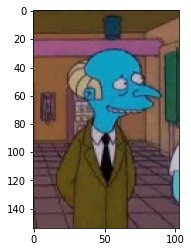

In [19]:
test_path = r'../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/charles_montgomery_burns_0.jpg'

img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [20]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [21]:
predictions = model.predict(prepare(img))

In [23]:
print(top_10[np.argmax(predictions[0])])

lisa_simpson


Very low accuracy in this model. I nees something to change...